In [1]:
require 'mxnet'
require 'mxnet/gluon'
require 'mxnet/gluon/loss'
require 'mxnet/gluon/nn'
require 'mxnet/gluon/trainer'

require 'gnuplot'
require 'rmagick'

true

In [2]:
epochs = 10
batch_size = 100
learning_rate = 0.01

0.01

In [3]:
data_ctx = model_ctx = MXNet.gpu

#<MXNet::Context:0x00007fbf7a4d1048 @device_type_id=2, @device_id=0>

In [4]:
def transform(data, label)
  [data.as_type(:float32) / 255, label]
end
train_data = MXNet::Gluon::Data::DataLoader.new(
  MXNet::Gluon::Data::Vision::MNIST.new(train: true, transform: method(:transform)),
  batch_size: batch_size, shuffle: true
)
test_data = MXNet::Gluon::Data::DataLoader.new(
  MXNet::Gluon::Data::Vision::MNIST.new(train: false, transform: method(:transform)),
  batch_size: batch_size, shuffle: false
)

#<MXNet::Gluon::Data::DataLoader:0x00007fbf79a5f880 @dataset=#<MXNet::Gluon::Data::Vision::MNIST:0x00007fbf79a67d28 @train=false, @train_data=["train-images-idx3-ubyte.gz", "6c95f4b05d2bf285e1bfb0e7960c31bd3b3f8a7d"], @train_label=["train-labels-idx1-ubyte.gz", "2a80914081dc54586dbdf242f9805a6b8d2a15fc"], @test_data=["t10k-images-idx3-ubyte.gz", "c3a25af1f52dad7f726cce8cacb138654b760d48"], @test_label=["t10k-labels-idx1-ubyte.gz", "763e7fa3757d93b0cdec073cef058b2004252c17"], @namespace="mnist", @transform=#<Method: main.transform>, @data=
[[[[0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
   [0], 
 ...
<MXNet::NDArray 10000x28x28x1 @cpu(0)>, @label=Numo::UInt8#shape=[10000]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, ...], @root="/Users/tsundsted/.mxnet/datasets/mnist">, @pin_memory=false, @thread_pool=false, @batch_sampler=#<MXNet::Glu

In [5]:
net = MXNet::Gluon::NN::HybridSequential.new.tap do |net|
  net.with_name_scope do
    net.add(
      MXNet::Gluon::NN::Conv2D.new(channels: 6, kernel_size: 5, activation: :relu),
      MXNet::Gluon::NN::MaxPool2D.new(pool_size: 2, strides: 2),
      MXNet::Gluon::NN::Conv2D.new(channels: 16, kernel_size: 3, activation: :relu),
      MXNet::Gluon::NN::MaxPool2D.new(pool_size: 2, strides: 2),
      MXNet::Gluon::NN::Flatten.new,
      MXNet::Gluon::NN::Dense.new(120, activation: :relu),
      MXNet::Gluon::NN::Dense.new(84, activation: :relu),
      MXNet::Gluon::NN::Dense.new(10)
    )
  end
  net.init(ctx: model_ctx)
  net.hybridize
end

MXNet::Gluon::NN::HybridSequential(

)

In [6]:
softmax_cross_entropy = MXNet::Gluon::Loss::SoftmaxCrossEntropyLoss.new

MXNet::Gluon::Loss::SoftmaxCrossEntropyLoss(

)

In [7]:
trainer = MXNet::Gluon::Trainer.new(net.collect_params, :sgd, optimizer_params: {learning_rate: learning_rate})

#<MXNet::Gluon::Trainer:0x00007fbf7a4e8658 @params=[Parameter hybridsequential0_conv2d0_weight (shape=[6, 0, 5, 5], dtype=float32), Parameter hybridsequential0_conv2d0_bias (shape=[6], dtype=float32), Parameter hybridsequential0_conv2d1_weight (shape=[16, 0, 3, 3], dtype=float32), Parameter hybridsequential0_conv2d1_bias (shape=[16], dtype=float32), Parameter hybridsequential0_dense0_weight (shape=[120, 0], dtype=float32), Parameter hybridsequential0_dense0_bias (shape=[120], dtype=float32), Parameter hybridsequential0_dense1_weight (shape=[84, 0], dtype=float32), Parameter hybridsequential0_dense1_bias (shape=[84], dtype=float32), Parameter hybridsequential0_dense2_weight (shape=[10, 0], dtype=float32), Parameter hybridsequential0_dense2_bias (shape=[10], dtype=float32)], @compression_params=nil, @scale=1.0, @contexts=[#<MXNet::Context:0x00007fbf7a4d1048 @device_type_id=2, @device_id=0>], @optimizer=#<MXNet::Optimizer::SGD:0x00007fbf79a3faa8 @rescale_grad=1.0, @lr=0.01, @lr_scheduler=

In [8]:
losses = []
accuracies = []
failures = nil

epochs.times do |epoch|
  # training
  training_loss = 0.0
  train_data.each.with_index do |(data, label), i|
    data = data.as_in_context(model_ctx).reshape([-1, 1, 28, 28])
    label = label.as_in_context(model_ctx).reshape([-1, 1])
    loss = MXNet::Autograd.record do
      output = net.(data)
      softmax_cross_entropy.(output, label)
    end
    loss.backward
    trainer.step(data.shape[0])
    training_loss += MXNet::NDArray.mean(loss).as_scalar
    puts "completed #{i + 1} iterations of epoch #{epoch}" if (i + 1) % 100 == 0
  end
  losses << total_loss = training_loss / (60000 / batch_size)
  puts "training loss #{total_loss}"
  # testing
  total = 0.0
  correct = 0.0
  test_data.each.with_index do |(data, label), i|
    data = data.as_in_context(model_ctx).reshape([-1, 1, 28, 28])
    label = label.as_in_context(model_ctx).reshape([-1, 1])
    begin
      output = net.(data)
      total += output.shape.first
      good, bad = data.zip(output, label).partition { |_, o, l| o.to_a.index(o.to_a.max) == l.to_i }
      correct += good.length
      failures = bad
    end
  end
  accuracies << accuracy = correct / total
  puts "testing accuracy #{accuracy * 100}%"
end

completed 100 iterations of epoch 0
completed 200 iterations of epoch 0
completed 300 iterations of epoch 0
completed 400 iterations of epoch 0
completed 500 iterations of epoch 0
completed 600 iterations of epoch 0
training loss 2.3013837246100106
testing accuracy 11.35%
completed 100 iterations of epoch 1
completed 200 iterations of epoch 1
completed 300 iterations of epoch 1
completed 400 iterations of epoch 1
completed 500 iterations of epoch 1
completed 600 iterations of epoch 1
training loss 2.29980175892512
testing accuracy 11.35%
completed 100 iterations of epoch 2
completed 200 iterations of epoch 2
completed 300 iterations of epoch 2
completed 400 iterations of epoch 2
completed 500 iterations of epoch 2
completed 600 iterations of epoch 2
training loss 2.2969585653146107
testing accuracy 11.37%
completed 100 iterations of epoch 3
completed 200 iterations of epoch 3
completed 300 iterations of epoch 3
completed 400 iterations of epoch 3
completed 500 iterations of epoch 3
com

10

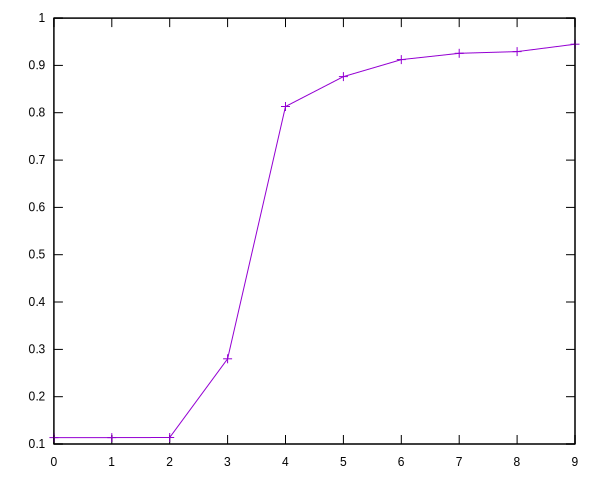

In [9]:
Gnuplot::Plot.new do |p|
  x = (0..epochs).map(&:to_f)
  p.data << Gnuplot::DataSet.new([x, accuracies]) do |ds|
    ds.with = "linespoints"
    ds.notitle
  end
end

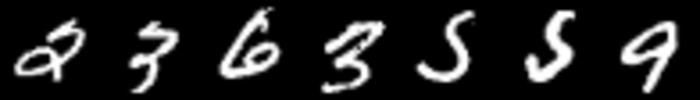

In [10]:
(0..[9, failures.length - 1].min).inject(Magick::ImageList.new) do |list, i|
  values, _, _ = failures[i]
  list << Magick::Image.constitute(28, 28, "I", values.reshape([784])).tap do |img|
    img.format = "png"
  end.resize(100, 100)
end.append(false)

In [11]:
(0..[9, failures.length - 1].min).map do |i|
  _, output, _ = failures[i]
  output.to_a.index(output.to_a.max)
end

[3, 7, 2, 8, 3, 6, 4]